<a href="https://colab.research.google.com/github/codingniket/Python-Training/blob/main/21-01-2026/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

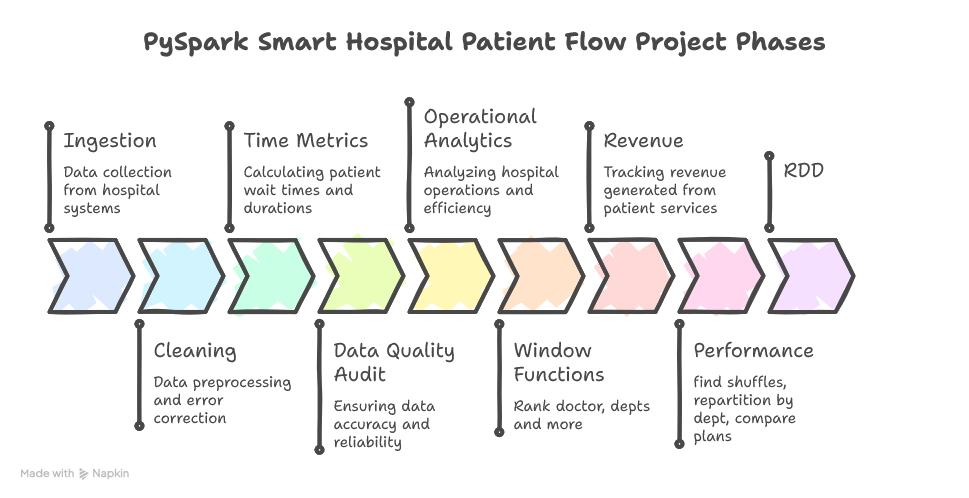

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql.functions import trim, col, when, to_date, sum as spark_sum, avg, desc, rank, lit, coalesce, isnull,try_to_timestamp,regexp_extract,initcap,regexp_replace,to_timestamp,unix_timestamp,dense_rank,count
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("Final").getOrCreate()


1.   We are importing `SparkSession` think it as a control room for all our spark activity
2.  `The Types` helps us to import particular schema types we want for our analysis


*   **StructType** It is like a table schema it defines the full structure of your DataFrame
*   **StructField** it describes one column: its name, data type, and whether it can be null

3. importing ready-made helper functions

4. creates a new session if none exists






# **--- PHASE 1: INGESTION ---**:


In [ ]:
df_raw = spark.read \
.option("header", "true") \
.option("inferSchema", "false") \
.csv("hospital_visits.csv")


**Why `.option("inferSchema", "false"` ?**

**A : ** forces every single column to be read as string

To avoid problem like corrupt data or Null data

In [ ]:
df_raw.show()
df_raw.printSchema()
df_raw.count()
df_raw.describe()

+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+
|visit_id|patient_id|doctor_id| department|hospital_city|       checkin_time| consult_start_time|   consult_end_time|     discharge_time|   visit_status|payment_amount|payment_mode|insurance_provider|rating|
+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+
| V100000|     P8243|     D247| Cardiology|    Hyderabad|22/01/2026 00:50:00|               NULL|               NULL|               NULL|      CANCELLED|       invalid|        Cash|              HDFC|  NULL|
| V100001|     P1663|     D185| Cardiology|       Mumbai|2026-01-11 13:47:00|2026-01-11 14:27:00|2026-01-11 14:40:00|2026-01-11 16:24:00|     REGISTERED|           757|

DataFrame[summary: string, visit_id: string, patient_id: string, doctor_id: string, department: string, hospital_city: string, checkin_time: string, consult_start_time: string, consult_end_time: string, discharge_time: string, visit_status: string, payment_amount: string, payment_mode: string, insurance_provider: string, rating: string]

In [ ]:

df_raw.count()

211381

In [ ]:
df_raw.isEmpty()

False

**Question 4**

1. Many data in `consult_start_time` & `consult_start_time` are Null and date and time
are not valid format

2. `rating` there are NULL Value also present here

3. **And many more**

# **--- PHASE 2: CLEANING ---**

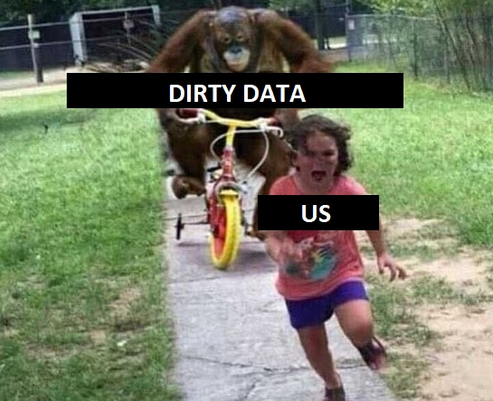

In [ ]:
df_trimmed = df_raw.select([trim(col(c)).alias(c) for c in df_raw.columns])
df_trimmed.show()

+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+
|visit_id|patient_id|doctor_id| department|hospital_city|       checkin_time| consult_start_time|   consult_end_time|     discharge_time|   visit_status|payment_amount|payment_mode|insurance_provider|rating|
+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+
| V100000|     P8243|     D247| Cardiology|    Hyderabad|22/01/2026 00:50:00|               NULL|               NULL|               NULL|      CANCELLED|       invalid|        Cash|              HDFC|  NULL|
| V100001|     P1663|     D185| Cardiology|       Mumbai|2026-01-11 13:47:00|2026-01-11 14:27:00|2026-01-11 14:40:00|2026-01-11 16:24:00|     REGISTERED|           757|

`trim(col(c))` modifies the column value, and `.alias(c)` ensures the output column keeps the same name

**Could you use any other function trim all  ?**

Yes selectExpr

In [ ]:
df_cleaned_pay = df_trimmed.withColumn(
    "payment_amount_clean",
    when(col("payment_amount") == "", None)
    .when(col("payment_amount") == "invalid", None)
    .otherwise(regexp_replace(col("payment_amount"), ",", "").cast(IntegerType()))
)

df_cleaned_pay.show()

+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+--------------------+
|visit_id|patient_id|doctor_id| department|hospital_city|       checkin_time| consult_start_time|   consult_end_time|     discharge_time|   visit_status|payment_amount|payment_mode|insurance_provider|rating|payment_amount_clean|
+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+--------------------+
| V100000|     P8243|     D247| Cardiology|    Hyderabad|22/01/2026 00:50:00|               NULL|               NULL|               NULL|      CANCELLED|       invalid|        Cash|              HDFC|  NULL|                NULL|
| V100001|     P1663|     D185| Cardiology|       Mumbai|2026-01-11 13:47:00|2026-01

Created a new column that will cleaned data
used `regexp_replace` to remove `,` with empty space



```
regexp_replace(column, pattern, replacement)
```

**IntegerType** turns blank to **NULL**


In [ ]:
def parse_mixed_time(c):
    return coalesce(
        to_timestamp(try_to_timestamp(c, lit("yyyy-MM-dd HH:mm:ss"))),
        to_timestamp(try_to_timestamp(c, lit("dd/MM/yyyy HH:mm:ss"))),
        to_timestamp(try_to_timestamp(c, lit("yyyy/MM/dd HH:mm:ss"))),
    )

time_cols = ["checkin_time", "consult_start_time", "consult_end_time", "discharge_time"]
df_parsed = df_cleaned_pay
for c in time_cols:
    df_parsed = df_parsed.withColumn(f"{c}_clean", parse_mixed_time(col(c)))

df_parsed.show()

+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+--------------------+-------------------+------------------------+----------------------+--------------------+
|visit_id|patient_id|doctor_id| department|hospital_city|       checkin_time| consult_start_time|   consult_end_time|     discharge_time|   visit_status|payment_amount|payment_mode|insurance_provider|rating|payment_amount_clean| checkin_time_clean|consult_start_time_clean|consult_end_time_clean|discharge_time_clean|
+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+--------------------+-------------------+------------------------+----------------------+--------------------+
| V100000|     P8243|     D247| Cardiology|   



*   coalesce → returns the first non-NULL value from its arguments.

*   to_timestamp → converts a string column to a timestamp type.

*   try_to_timestamp → tries to parse a string to timestamp without failing, returns NULL if it can’t.

*   lit → creates a literal value (like a constant) usable in Spark expressions.



What happens if **coalesce** finds NULL ?

**A** skips NULLs and returns the first non-NULL value; if all inputs are NULL, it returns NULL.

In [ ]:
df_flagged = df_parsed.withColumn("checkin_valid", col("checkin_time_clean").isNotNull()) \
    .withColumn("consult_start_valid", col("consult_start_time_clean").isNotNull()) \
    .withColumn("consult_end_valid", col("consult_end_time_clean").isNotNull()) \
    .withColumn("discharge_valid", col("discharge_time_clean").isNotNull())

df_flagged.show()

+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+--------------------+-------------------+------------------------+----------------------+--------------------+-------------+-------------------+-----------------+---------------+
|visit_id|patient_id|doctor_id| department|hospital_city|       checkin_time| consult_start_time|   consult_end_time|     discharge_time|   visit_status|payment_amount|payment_mode|insurance_provider|rating|payment_amount_clean| checkin_time_clean|consult_start_time_clean|consult_end_time_clean|discharge_time_clean|checkin_valid|consult_start_valid|consult_end_valid|discharge_valid|
+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+--------------------+


# **Data is now cleaned**

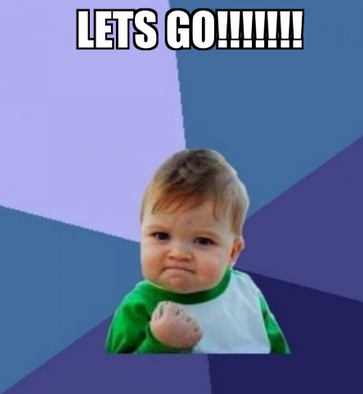

# **--- PHASE 3: DERIVED TIME METRICS ---**

In [ ]:
# Compute metrics in minutes using unix_timestamp
df_metrics = df_flagged.withColumn(
    "waiting_time",
    (unix_timestamp("consult_start_time_clean") - unix_timestamp("checkin_time_clean")) / 60
).withColumn(
    "consultation_time",
    (unix_timestamp("consult_end_time_clean") - unix_timestamp("consult_start_time_clean")) / 60
).withColumn(
    "total_visit_time",
    (unix_timestamp("discharge_time_clean") - unix_timestamp("checkin_time_clean")) / 60
)

df_metrics.show()

+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+---------------+--------------+------------+------------------+------+--------------------+-------------------+------------------------+----------------------+--------------------+-------------+-------------------+-----------------+---------------+------------+-----------------+----------------+
|visit_id|patient_id|doctor_id| department|hospital_city|       checkin_time| consult_start_time|   consult_end_time|     discharge_time|   visit_status|payment_amount|payment_mode|insurance_provider|rating|payment_amount_clean| checkin_time_clean|consult_start_time_clean|consult_end_time_clean|discharge_time_clean|checkin_valid|consult_start_valid|consult_end_valid|discharge_valid|waiting_time|consultation_time|total_visit_time|
+--------+----------+---------+-----------+-------------+-------------------+-------------------+-------------------+---------------

In [ ]:
# Flag negative or null values (Requirement: Negative or null values must be flagged)
# We create a simple flag column "is_metric_valid" for demonstration
df_metrics = df_metrics.withColumn(
    "has_negative_metrics",
    (col("waiting_time") < 0) | (col("consultation_time") < 0) | (col("total_visit_time") < 0)
)
df_metrics.select("visit_id", "waiting_time", "consultation_time", "total_visit_time", "has_negative_metrics").show()

+--------+------------+-----------------+----------------+--------------------+
|visit_id|waiting_time|consultation_time|total_visit_time|has_negative_metrics|
+--------+------------+-----------------+----------------+--------------------+
| V100000|        NULL|             NULL|            NULL|                NULL|
| V100001|        40.0|             13.0|           157.0|               false|
| V100002|        32.0|             44.0|           128.0|               false|
| V100003|         0.0|            -15.0|            59.0|                true|
| V100004|        24.0|             19.0|            98.0|               false|
| V100005|        23.0|             31.0|           165.0|               false|
| V100006|        39.0|            -14.0|            48.0|                true|
| V100007|        35.0|             35.0|           183.0|               false|
| V100008|        17.0|             27.0|           100.0|               false|
| V100009|        33.0|             -5.0

In [ ]:
print("--- PHASE 4: DATA QUALITY AUDIT ---")

# 1. Count logic errors
audit_1 = df_metrics.filter(col("consult_start_time_clean") < col("checkin_time_clean")).count()
audit_2 = df_metrics.filter(col("consult_end_time_clean") < col("consult_start_time_clean")).count()
audit_3 = df_metrics.filter(col("discharge_time_clean") < col("consult_end_time_clean")).count()


--- PHASE 4: DATA QUALITY AUDIT ---


In [ ]:

# 2. Count DISCHARGED visits with missing consult_end_time
audit_4 = df_metrics.filter(
    (col("visit_status") == "DISCHARGED") & (col("consult_end_time_clean").isNull())
).count()

# 3. Count invalid payment_amount (Where original was not null/empty but clean is null)
audit_5 = df_metrics.filter(
    (col("payment_amount") != "") &
    (col("payment_amount").isNotNull()) &
    (col("payment_amount_clean").isNull())
)

# 4. Count CANCELLED visits
audit_6 = df_metrics.filter(col("visit_status") == "CANCELLED").count()




In [ ]:
print(f"Logic Error (Start < Checkin): {audit_1}")
print(f"Logic Error (End < Start): {audit_2}")
print(f"Logic Error (Discharge < End): {audit_3}")
print(f"Discharged with missing End Time: {audit_4}")
print(f"Invalid Payment Amounts: {audit_5}")
print(f"Cancelled Visits: {audit_6}")

Logic Error (Start < Checkin): 37516
Logic Error (End < Start): 35207
Logic Error (Discharge < End): 26100
Discharged with missing End Time: 3922
Invalid Payment Amounts: DataFrame[visit_id: string, patient_id: string, doctor_id: string, department: string, hospital_city: string, checkin_time: string, consult_start_time: string, consult_end_time: string, discharge_time: string, visit_status: string, payment_amount: string, payment_mode: string, insurance_provider: string, rating: string, payment_amount_clean: int, checkin_time_clean: timestamp, consult_start_time_clean: timestamp, consult_end_time_clean: timestamp, discharge_time_clean: timestamp, checkin_valid: boolean, consult_start_valid: boolean, consult_end_valid: boolean, discharge_valid: boolean, waiting_time: double, consultation_time: double, total_visit_time: double, has_negative_metrics: boolean]
Cancelled Visits: 52858


In [ ]:
print("--- PHASE 5: OPERATIONAL ANALYTICS ---")

# 1. Avg waiting time per department
df_metrics.groupBy("department").agg(avg("waiting_time").alias("avg_wait_min")).show()

# 2. Avg consultation time per doctor
df_metrics.groupBy("doctor_id").agg(avg("consultation_time").alias("avg_consult_min")).show()

# 3. Departments with longest patient queues (Count of visits or Sum of wait time)
df_metrics.groupBy("department").count().orderBy(desc("count")).show()

# 4. Cities with longest discharge delays (assuming Total Visit Time acts as proxy for delay/length)
df_metrics.groupBy("hospital_city").agg(avg("total_visit_time").alias("avg_visit_len")).orderBy(desc("avg_visit_len")).show()

# 5. Cancellation rate per department
total_per_dept = df_metrics.groupBy("department").count().withColumnRenamed("count", "total")
cancelled_per_dept = df_metrics.filter(col("visit_status") == "CANCELLED").groupBy("department").count().withColumnRenamed("count", "cancelled")

# Join and calculate rate
total_per_dept.join(cancelled_per_dept, "department", "left") \
    .withColumn("cancellation_rate", coalesce(col("cancelled"), lit(0)) / col("total")) \
    .show()

--- PHASE 5: OPERATIONAL ANALYTICS ---
+--------------------+------------------+
|          department|      avg_wait_min|
+--------------------+------------------+
|General2026-02-21...|              NULL|
| 2026-02-22 23:39:00|              NULL|
|               12649|              NULL|
|             General| 14.88843273057758|
|           Neurology|15.085041047816006|
|         Dermatology|14.771773363684556|
|                Ort1|              NULL|
|          Cardiology| 15.04040404040404|
|          Pediatrics|14.964214276784599|
| 2026-01-22 18:18:00|              NULL|
|                Ort0|              NULL|
|         Orthopedics|15.045879327646764|
|                5755|              NULL|
|          Generalogy|              -8.0|
|         Dermatol549|              NULL|
| 2026-02-19 02:15:00|              NULL|
+--------------------+------------------+

+---------+------------------+
|doctor_id|   avg_consult_min|
+---------+------------------+
|     D738|23.3244444444444

In [ ]:
print("--- PHASE 6: WINDOW FUNCTIONS ---")

# 1. Rank doctors by Shortest consultation time & Highest ratings
# Note: Rating is string in source, need to cast to float.
df_metrics = df_metrics.withColumn("rating_float", col("rating").cast("float"))

# Define the window: rank by shortest consultation time, then highest rating
w_doc = Window.orderBy(
    col("consultation_time").asc_nulls_last(),
    col("rating_float").desc_nulls_last()
)

# Final query: only DISCHARGED + consultation_time is NOT NULL
df_ranked = df_metrics.filter(
    (col("visit_status") == "DISCHARGED") &
    col("consultation_time").isNotNull()
).select(
    "doctor_id",
    "consultation_time",
    "rating_float"
).withColumn(
    "doc_rank",
    rank().over(w_doc)
)

df_ranked.show(truncate=False)



--- PHASE 6: WINDOW FUNCTIONS ---
+---------+-----------------+------------+--------+
|doctor_id|consultation_time|rating_float|doc_rank|
+---------+-----------------+------------+--------+
|D673     |-15.0            |5.0         |1       |
|D560     |-15.0            |5.0         |1       |
|D560     |-15.0            |5.0         |1       |
|D605     |-15.0            |4.9         |4       |
|D221     |-15.0            |4.9         |4       |
|D913     |-15.0            |4.9         |4       |
|D626     |-15.0            |4.9         |4       |
|D913     |-15.0            |4.9         |4       |
|D605     |-15.0            |4.9         |4       |
|D893     |-15.0            |4.9         |4       |
|D638     |-15.0            |4.9         |4       |
|D659     |-15.0            |4.9         |4       |
|D893     |-15.0            |4.9         |4       |
|D626     |-15.0            |4.9         |4       |
|D638     |-15.0            |4.9         |4       |
|D659     |-15.0            |4

In [ ]:
# 1. First, compute aggregates per department
df_dept_stats = df_metrics.groupBy("department").agg(
    # Avg waiting time (only valid rows)
    avg(when(col("waiting_time").isNotNull() & (col("waiting_time") >= 0), col("waiting_time")))
        .alias("avg_waiting_time_minutes"),

    # Total visits per department
    count("*").alias("total_visits"),

    # Cancelled visits
    spark_sum(when(col("visit_status") == "CANCELLED", 1).otherwise(0)).alias("cancelled_count")
)

# 2. Calculate cancellation rate (%)
df_dept_stats = df_dept_stats.withColumn(
    "cancellation_rate_percent",
    (col("cancelled_count") / col("total_visits")) * 100
)

# 3. Define two windows (global ranking – no partitionBy)
w_wait = Window.orderBy(col("avg_waiting_time_minutes").desc_nulls_last())
w_cancel = Window.orderBy(col("cancellation_rate_percent").desc_nulls_last())

# 4. Add ranks
df_ranked_depts = df_dept_stats.withColumn(
    "rank_by_waiting_time", rank().over(w_wait)
).withColumn(
    "rank_by_cancellation_rate", rank().over(w_cancel)
).orderBy("rank_by_waiting_time")  # sort by worst waiting first

# 5. Show result
df_ranked_depts.select(
    "department",
    "avg_waiting_time_minutes",
    "rank_by_waiting_time",
    "cancellation_rate_percent",
    "rank_by_cancellation_rate",
    "total_visits",
    "cancelled_count"
).show(truncate=False)

+--------------------------+------------------------+--------------------+-------------------------+-------------------------+------------+---------------+
|department                |avg_waiting_time_minutes|rank_by_waiting_time|cancellation_rate_percent|rank_by_cancellation_rate|total_visits|cancelled_count|
+--------------------------+------------------------+--------------------+-------------------------+-------------------------+------------+---------------+
|Orthopedics               |20.013913789071633      |1                   |25.457130669699986       |1                        |35165       |8952           |
|General                   |20.004352087825918      |2                   |24.7315206215012         |6                        |35012       |8659           |
|Neurology                 |19.9590113125678        |3                   |24.736438293881957       |5                        |35191       |8705           |
|Cardiology                |19.9281340884739        |4          

In [ ]:
# 3. Identify Top 3 efficient doctors per department (Efficiency = Shortest Consult Time for demo)
w_dept_doc = Window.partitionBy("department").orderBy(col("consultation_time").asc())

df_metrics.filter(col("visit_status") == "DISCHARGED") \
    .withColumn("rank", rank().over(w_dept_doc)) \
    .filter(col("rank") <= 3) \
    .select("department", "doctor_id", "consultation_time", "rank") \
    .show()

+----------+---------+-----------------+----+
|department|doctor_id|consultation_time|rank|
+----------+---------+-----------------+----+
|Cardiology|     D720|             NULL|   1|
|Cardiology|     D616|             NULL|   1|
|Cardiology|     D384|             NULL|   1|
|Cardiology|     D238|             NULL|   1|
|Cardiology|     D648|             NULL|   1|
|Cardiology|     D820|             NULL|   1|
|Cardiology|     D249|             NULL|   1|
|Cardiology|     D220|             NULL|   1|
|Cardiology|     D659|             NULL|   1|
|Cardiology|     D996|             NULL|   1|
|Cardiology|     D922|             NULL|   1|
|Cardiology|     D834|             NULL|   1|
|Cardiology|     D647|             NULL|   1|
|Cardiology|     D807|             NULL|   1|
|Cardiology|     D658|             NULL|   1|
|Cardiology|     D848|             NULL|   1|
|Cardiology|     D519|             NULL|   1|
|Cardiology|     D576|             NULL|   1|
|Cardiology|     D938|            

In [ ]:
df_dept_wait = df_metrics.groupBy("department").agg(

        avg(
            when(
                col("waiting_time").isNotNull() & (col("waiting_time") >= 0),
                col("waiting_time")
            )
        ).alias("avg_waiting_time_minutes")
)

# 2. Define window → rank by HIGHEST avg wait (worst first)
w_overload = Window.orderBy(
    col("avg_waiting_time_minutes").desc_nulls_last()
)

# 3. Add rank + filter top 3 worst
df_overloaded = df_dept_wait.withColumn(
    "overload_rank",
    rank().over(w_overload)
).filter(col("overload_rank") <= 3)

# 4. Show sorted by rank (1 = most overloaded)
df_overloaded.select(
    "department",
    "avg_waiting_time_minutes",
    "overload_rank"
).orderBy("overload_rank").show(truncate=False)

+-----------+------------------------+-------------+
|department |avg_waiting_time_minutes|overload_rank|
+-----------+------------------------+-------------+
|Orthopedics|20.013913789071633      |1            |
|General    |20.004352087825918      |2            |
|Neurology  |19.9590113125678        |3            |
+-----------+------------------------+-------------+



In [ ]:
print("--- PHASE 7: REVENUE ANALYTICS ---")

# 1. Total revenue per department
df_metrics.groupBy("department").agg(spark_sum("payment_amount_clean").alias("total_revenue")).show()

# 2. Revenue per insurance provider
df_metrics.groupBy("insurance_provider").agg(spark_sum("payment_amount_clean").alias("revenue")).show()

# 3. Average bill amount per city
df_metrics.groupBy("hospital_city").agg(avg("payment_amount_clean").alias("avg_bill")).show()

# 4. Compare insured vs non-insured revenue
# Assuming "None" or null implies non-insured
df_metrics.withColumn("is_insured",
                      when((col("insurance_provider") == "None") | (col("insurance_provider").isNull()), "Non-Insured")
                      .otherwise("Insured")) \
          .groupBy("is_insured").agg(spark_sum("payment_amount_clean").alias("revenue")).show()

--- PHASE 7: REVENUE ANALYTICS ---


{"ts": "2026-01-21 04:03:01.372", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[CAST_INVALID_INPUT] The value '4.2' of the type \"STRING\" cannot be cast to \"INT\" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018", "context": {"file": "line 5 in cell [10]", "line": "", "fragment": "cast", "errorClass": "CAST_INVALID_INPUT"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o806.showString.\n: org.apache.spark.SparkNumberFormatException: [CAST_INVALID_INPUT] The value '4.2' of the type \"STRING\" cannot be cast to \"INT\" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018\n== DataFrame ==\n\"cast\" was called from\nline 5 in cell [10]\n\n\tat org.apache.spark.sql.errors.QueryExecutionErrors$.

NumberFormatException: [CAST_INVALID_INPUT] The value '4.2' of the type "STRING" cannot be cast to "INT" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018
== DataFrame ==
"cast" was called from
line 5 in cell [10]


# **--- PHASE 8: PERFORMANCE ENGINEERING ---**

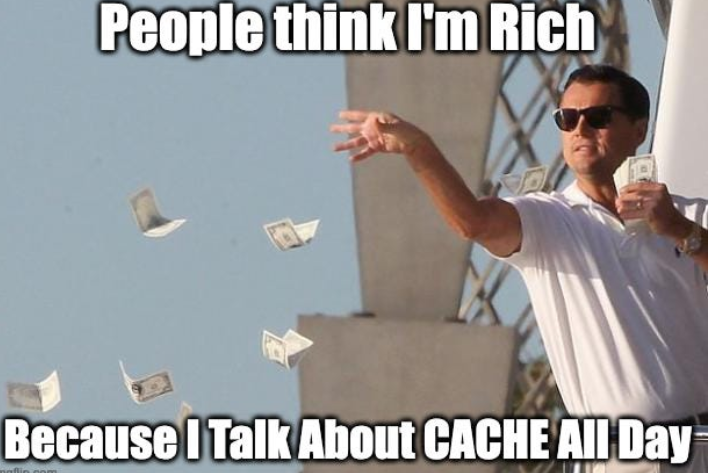

In [ ]:
df_flagged.cache()

**What is Cache()?**

`.cache()` tells Spark to store the DataFrame df_metrics in memory (RAM) so that future actions (like .count(), .show(), aggregations, joins) on it run much faster

In [ ]:
df_metrics.cache()
print(f"Dataset cached. Count: {df_metrics.count()}")

**What does explain True does?**
`.explain(True)` prints the full detailed execution plan of a Spark DataFrame operation/query

Parsed Logical Plan → how Spark first understands code logically

Analyzed Logical Plan → after validation & type checks

Optimized Logical Plan → after Catalyst optimizer improvements

Physical Plan → actual steps Spark will run (with stages, shuffles, exchanges, etc.)

**What is shuffle mean?**

Shuffle means moving and reorganizing data across different partitions (and often across different machines/nodes in the cluster) so that data with the same key ends up together for processing.

**Where is the shuffle in this explain plan?**

A: In the Exchange rangepartitioning line right before the final Sort it's a range shuffle caused by the global ORDER BY consultation_time.

In [ ]:
print("Explain Plan for Doctor Ranking:")
df_metrics.orderBy("consultation_time").explain(True)

Explain Plan for Doctor Ranking:
== Parsed Logical Plan ==
'Sort ['consultation_time ASC NULLS FIRST], true
+- Project [visit_id#449, patient_id#450, doctor_id#451, department#452, hospital_city#453, checkin_time#454, consult_start_time#455, consult_end_time#456, discharge_time#457, visit_status#458, payment_amount#459, payment_mode#460, insurance_provider#461, rating#462, payment_amount_clean#520, checkin_time_clean#581, consult_start_time_clean#582, consult_end_time_clean#583, discharge_time_clean#584, checkin_valid#657, consult_start_valid#658, consult_end_valid#659, discharge_valid#660, waiting_time#745, consultation_time#746, ... 3 more fields]
   +- Project [visit_id#449, patient_id#450, doctor_id#451, department#452, hospital_city#453, checkin_time#454, consult_start_time#455, consult_end_time#456, discharge_time#457, visit_status#458, payment_amount#459, payment_mode#460, insurance_provider#461, rating#462, payment_amount_clean#520, checkin_time_clean#581, consult_start_time_cl

In [ ]:
df_metrics.orderBy("waiting_time").explain(True)

== Parsed Logical Plan ==
'Sort ['waiting_time ASC NULLS FIRST], true
+- Project [visit_id#449, patient_id#450, doctor_id#451, department#452, hospital_city#453, checkin_time#454, consult_start_time#455, consult_end_time#456, discharge_time#457, visit_status#458, payment_amount#459, payment_mode#460, insurance_provider#461, rating#462, payment_amount_clean#520, checkin_time_clean#581, consult_start_time_clean#582, consult_end_time_clean#583, discharge_time_clean#584, checkin_valid#657, consult_start_valid#658, consult_end_valid#659, discharge_valid#660, waiting_time#745, consultation_time#746, ... 3 more fields]
   +- Project [visit_id#449, patient_id#450, doctor_id#451, department#452, hospital_city#453, checkin_time#454, consult_start_time#455, consult_end_time#456, discharge_time#457, visit_status#458, payment_amount#459, payment_mode#460, insurance_provider#461, rating#462, payment_amount_clean#520, checkin_time_clean#581, consult_start_time_clean#582, consult_end_time_clean#583, d

**Identify shuffle stages (Look for Exchange in the explain plan above)**




```
   +- Exchange rangepartitioning(consultation_time#20430 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=4543]
```




```
   +- Exchange rangepartitioning(waiting_time#20429 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=4553]
```




**Q: Is this shuffle bad?**

A: Yes, it's expensive (network + disk I/O). For global ranking it's unavoidable, but for department-wise ranking we can reduce it using window partitionBy("department").

In [ ]:
# 4. Repartition by department
df_repartitioned = df_metrics.repartition(col("department"))

**Q: What does df.repartition(col("department")) do?**

A: It redistributes the DataFrame so that all records for the same department are placed in the same partitions, reducing future shuffles in department-based aggregations and window functions.

In [ ]:
df_metrics.rdd.getNumPartitions()

2

**Q: Why not exactly 7 partitions for 7 departments?**

A: Spark hash partitioning spreads data across a fixed number of buckets (controlled by config).

In [ ]:
# 5. Compare execution plans
print("Explain Plan AFTER Repartitioning:")
df_repartitioned.groupBy("department").count().explain()

Explain Plan AFTER Repartitioning:
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[department#452], functions=[count(1)])
   +- HashAggregate(keys=[department#452], functions=[partial_count(1)])
      +- Exchange hashpartitioning(department#452, 200), REPARTITION_BY_COL, [plan_id=1578]
         +- Project [trim(department#20, None) AS department#452]
            +- FileScan csv [department#20] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/hospital_visits.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<department:string>




# **"--- PHASE 9: RDD ---"**

In [ ]:
rdd_discharged = df_metrics.filter(col("visit_status") == "DISCHARGED").rdd

**What is RDD**

It converts the filtered DataFrame into an RDD so we can perform low-level map-reduce

Resilient Distributed Dataset

data is split across machines, fault-tolerant, and you process it using low-level operations like map and reduce.

In [ ]:
# 2. Compute Total hospital revenue using reduce
# Map to (payment_amount), then reduce
total_rev = rdd_discharged \
    .map(lambda row: row["payment_amount_clean"] if row["payment_amount_clean"] else 0) \
    .reduce(lambda x, y: x + y)

print(f"Total Revenue (RDD Reduce): {total_rev}")

# Visit count per city using map-reduce
city_counts = rdd_discharged \
    .map(lambda row: (row["hospital_city"], 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .collect()

print(f"Visit Counts per City (RDD Map-Reduce): {city_counts}")



Total Revenue (RDD Reduce): 491684047
Visit Counts per City (RDD Map-Reduce): [('Pune', 7533), ('Delhi', 7561), ('Mumbai', 7440), ('Hyderabad', 7503), ('Kolkata', 7582), ('Bangalore', 7398), ('Chennai', 7650)]


In [ ]:
# 3. Explain why DataFrames are superior
print("""
Why DataFrames are superior for healthcare analytics:
1. Catalyst Optimizer: DataFrames utilize the Catalyst optimizer for logical and physical query optimization, which RDDs lack.
2. Tungsten Execution Engine: DataFrames use off-heap memory management and code generation, processing data faster than RDD python objects.
3. Structured Data Handling: Healthcare data (timestamps, currency) is structured; DataFrames enforce schema, reducing runtime type errors compared to RDDs.
""")

# Stop Spark
# spark.stop()


Why DataFrames are superior for healthcare analytics:
1. Catalyst Optimizer: DataFrames utilize the Catalyst optimizer for logical and physical query optimization, which RDDs lack.
2. Tungsten Execution Engine: DataFrames use off-heap memory management and code generation, processing data faster than RDD python objects.
3. Structured Data Handling: Healthcare data (timestamps, currency) is structured; DataFrames enforce schema, reducing runtime type errors compared to RDDs.



**Parquet and ORC**

are both popular columnar file formats used in big data like Spark — they store data by columns instead of rows (like CSV), making analytics queries much faster and files much smaller.

1. Parquet = "Modern, fast, Spark-friendly columnar format — most people choose this for analytics today."


2. ORC = "Older Hive-optimized columnar format — great compression and ACID, but Parquet usually wins in Spark world."